In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We have reduced the neural networks to the level of individual scalers, which is excessive.  
Our goal is to make it somewhat usable.

In [2]:
### Derivative
### If you increase the value of x by a slight sumber(say h), how does the fuction respond, does it goes up or down and by what sensitivity.
def f(x):
    return x**2

x = 3.0
h = 0.0001

# df/dx = 2x
(f(x + h) - f(x))/h

6.000100000012054

In [3]:
# Derivatives of d with respect to a,b, and c
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b +  c
a += h # Slightly increasing the value of a
d2 = a*b +  c

print("d1:", d1)
print("d2:", d2)
print("slope:", (d2-d1)/h) # The rate at which 'd' will increase/decrease as we scale 'a'. 

d1: 4.0
d2: 3.999699999999999
slope: -3.000000000010772


In [4]:
class Value:
    def __init__(self, data, _parents=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 
        self._backward = lambda: None
        self._prev = set(_parents)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out 

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):  
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward 
        return out 

    def __rmul__(self, other):
        return self * other

        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
            
        return out

    def backward(self):
        topo = [] # output
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)       

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()





In [5]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')

c = a + b * b

In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

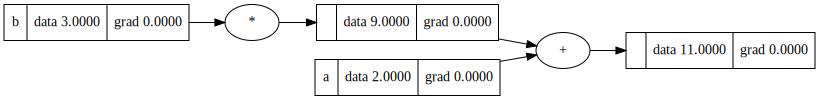

In [7]:
draw_dot(c)

In [91]:
x1 = Value(2.0, label='x1')
x2 = Value(3.0, label='x2')

w1 = Value(5.0, label='w1')
w2 = Value(0.5, label='w2')

y = x1*w1 + x2*w2
y.label=  'y'

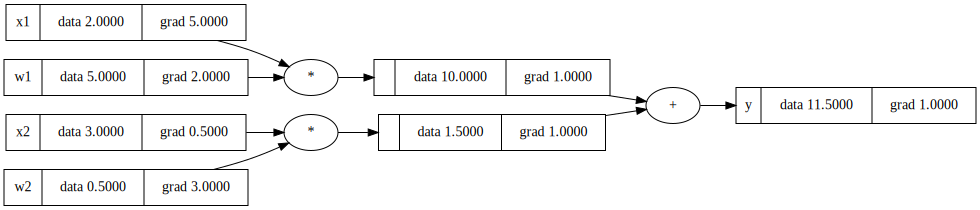

In [94]:
draw_dot(y)

In [8]:
y.backward()

NameError: name 'y' is not defined

In [9]:
# Building a NN
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out  
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
  
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.24972316471072808)

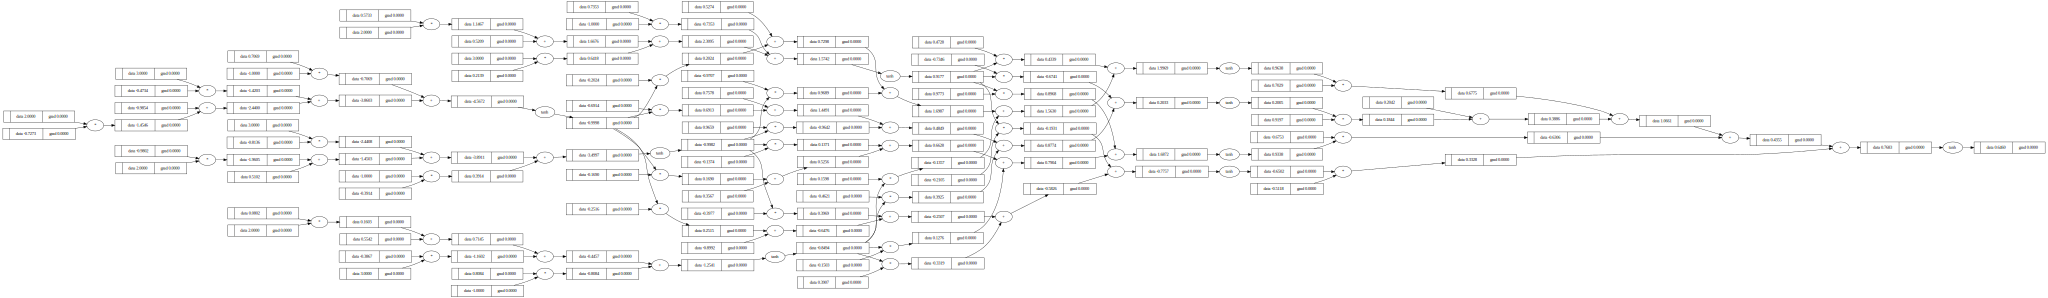

In [97]:
draw_dot(n(x))